# Import necessary PyTorch modules

In this experiment, we develop a baseline CSRNET to generate density maps of crowd detection on ShanghaiTech dataset. 😀

In [1]:
import torch.nn as nn
import torch
from torchvision import models
from utils import save_net,load_net


In [2]:
!pip install kornia


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

# Load model of CSRNET + Convolutional Block Attention Module (CBAM)
the CBAM is located in between the frontend and backend

*   Instead of SGD optimizer > change to Adam Optimizer
*   Show significant changes of training time

And then we checked the model works without errors (shape compatibility between layers) and verify output size is correct\\



In [3]:
# This is CSRNet with CBAM attention
# Have channel and spatial attention that arrange in sequential arrangement

class ChannelAttention(nn.Module):
    #global avg pooling and max pooling-> compress feature maps into 1x1xC
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
    #pass both tru an MLP (2 conv layer) and sum
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid() #gives weight per channel

        #multiply back into input x

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out) # use both avg and max pooling simultaneously



class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7): #use 7x7 convo
        super(SpatialAttention, self).__init__()

        #concatenate them -> 2xHxW
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1) #concatenate avg and max pooling
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x


    #sequence of convo and pooling layers
def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    d_rate = 2 if dilation else 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

class CSRNet_CBAM(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet_CBAM, self).__init__()
        self.seen = 0
        # Same frontend and backend configuration as original CSRNet
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]

        self.frontend = make_layers(self.frontend_feat)
        self.cbam = CBAM(512)  # Add CBAM after frontend output,CBAM expects input with 512 channels (output of frontend)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

        # Load VGG16 pretrained weights into frontend
        if not load_weights:
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            vgg_state = mod.features.state_dict()
            frontend_state = self.frontend.state_dict()
            matched_weights = {k: v for k, v in vgg_state.items() if k in frontend_state and v.size() == frontend_state[k].size()}
            frontend_state.update(matched_weights)
            self.frontend.load_state_dict(frontend_state)

    def forward(self, x):
        x = self.frontend(x)
        x = self.cbam(x)        # Apply CBAM here
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [17]:
model = CSRNet_CBAM()
x = torch.rand((1,3,255,255))
model(x).shape

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 31, 31])

# Training the proposed model and evaluate

For the training, we use dataset of json file that form with

*   Global Gaussian method (proposed method)
*   Geometry Adaptive Gaussian (original method by CSRNet)

The model will be evaluate through
*   MAE / RMSE / SSIM / PSNR for every epoch
*   print best MAE for the current epoch

-----

For evaluation, we presented the result of training in graph

The best metrics summary present in 3 .png file
*   1. Loss_history.png
*   2. Count Accuracy.png
*   3. Map Structure.png

The final accuracy summary show all evalution metrics in 1 .png file



In [77]:
!python train.py trainned.json valided.json 0 0



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
epoch 0, processed 0 samples, lr 0.0000100000
Epoch: [0][0/400]	Time 0.601 (0.601)	Data 0.016 (0.016)	Loss 19.3688 (19.3688)	
Epoch: [0][100/400]	Time 0.064 (0.062)	Data 0.017 (0.018)	Loss 110.5893 (37.9288)	
Epoch: [0][200/400]	Time 0.029 (0.055)	Data 0.011 (0.019)	Loss 5.3503 (30.6570)	
Epoch: [0][300/400]	Time 0.030 (0.052)	Data 0.010 (0.020)	Loss 0.8691 (28.3534)	
 * MAE: 158.


# Test the previous model using unseen data

Choose any images that has ground truth to visualise trainned model works

In [79]:
import torch
from model import CSRNet_CBAM  # Make sure this matches your model definition

model = CSRNet_CBAM() # Load the best model checkpoint
checkpoint = torch.load('0model_best.pth.tar', map_location='cpu')  # or 'cuda' if using GPU

# Load the model weights from checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set model to evaluation mode
model.eval()

CSRNet_CBAM(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [80]:
import torch

# Load the checkpoint
checkpoint = torch.load('0model_best.pth.tar', map_location='cpu')  # change path if needed

# Print all keys in the checkpoint
print("Checkpoint keys:", checkpoint.keys())

Checkpoint keys: dict_keys(['epoch', 'arch', 'model_state_dict', 'best_mae', 'optimizer'])


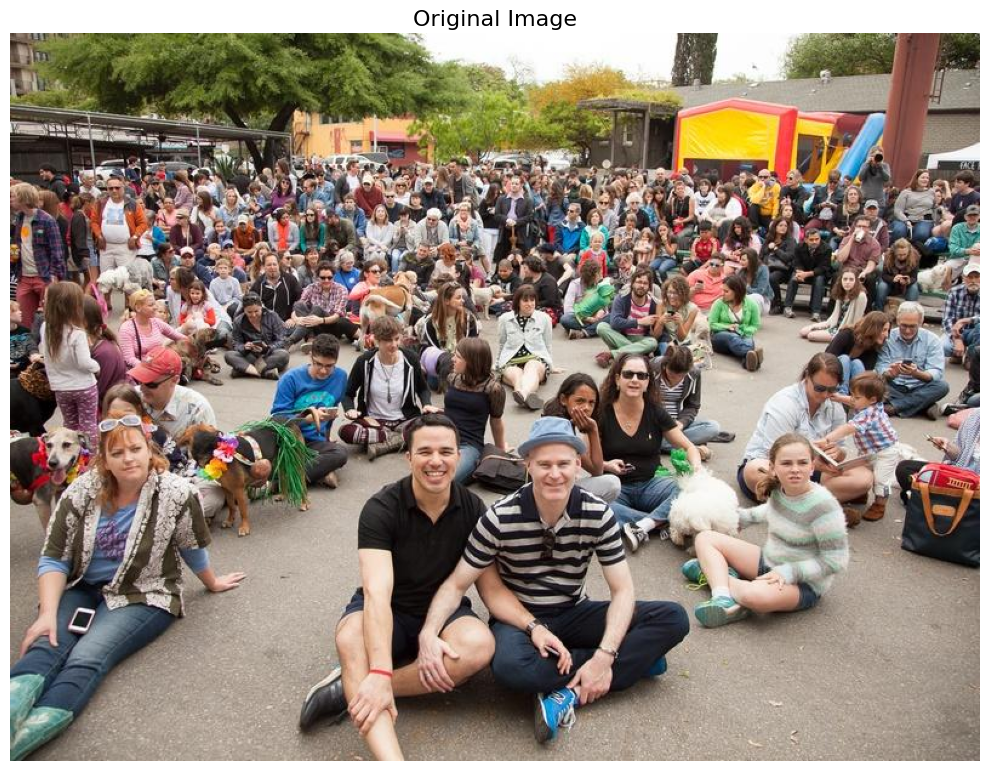

In [82]:
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title('Original Image', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

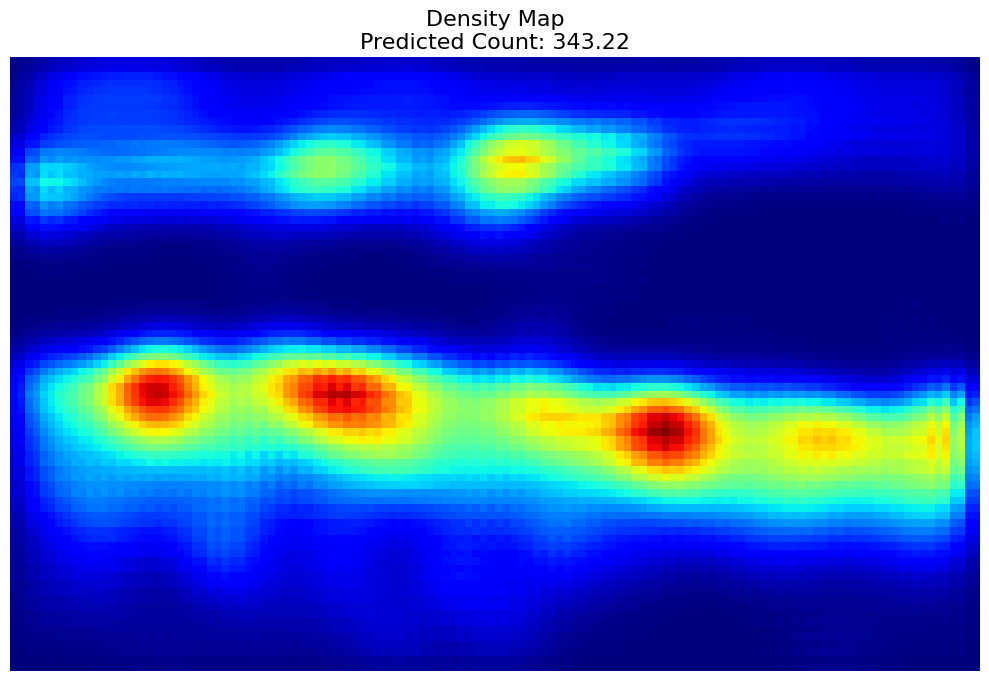

In [83]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_paths_A = "/content/111.jpeg"  # tested image
img = Image.open(img_paths_A).convert('RGB')
img_tensor = transform(img).unsqueeze(0)

with torch.no_grad():
    output = model(img_tensor)

predicted_count = output.sum().item()

# Display Density Map and Predicted Count
plt.figure(figsize=(10, 8))
plt.imshow(output.squeeze().numpy(), cmap='jet')
plt.title(f'Density Map\nPredicted Count: {predicted_count:.2f}', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Load model of CSRNet

The baseline code is referred to the original model (CSRNET 2018)

 -------
The trainning step is repeated but using train and val json file of

*   Global Gaussian method (proposed method)
*   Geometry Adaptive Gaussian (original method by CSRNet)




In [8]:
# This is baseline model CSRNet
# 10 convolutional layeas frontend + dilated layer as backend

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512, 256, 128, 64]

        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True) # keep the dilation rate = 2
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1) # 1/8 of the original input size.

        # Load VGG16 pretrained weights into frontend
        if not load_weights:
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            frontend_items = list(self.frontend.state_dict().items())
            mod_items = list(mod.state_dict().items())
            for i in range(len(frontend_items)):
                frontend_items[i][1].data[:] = mod_items[i][1].data[:]

    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)] #
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


In [10]:
model = CSRNet()
x = torch.rand((1,3,255,255))
model(x).shape

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1, 31, 31])

In [12]:
!python train.py trainned.json valided.json 0 0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
epoch 0, processed 0 samples, lr 0.0000100000
Epoch: [0][0/400]	Time 0.989 (0.989)	Data 0.032 (0.032)	Loss 3.7189 (3.7189)	
Epoch: [0][100/400]	Time 0.032 (0.060)	Data 0.021 (0.019)	Loss 17.8578 (35.0901)	
Epoch: [0][200/400]	Time 0.039 (0.053)	Data 0.026 (0.020)	Loss 6.6948 (32.2267)	
Epoch: [0][300/400]	Time 0.038 (0.051)	Data 0.018 (0.020)	Loss 3.7657 (28.0336)	
 * MAE: 162.574

**test the model csrnet + global gaussian**

In [13]:
import torch
from model import CSRNet # Make sure this matches your model definition

model = CSRNet()
# Load the best model checkpoint
checkpoint = torch.load('0model_best.pth.tar', map_location='cpu')  # or 'cuda' if using GPU

# Load the model weights from checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set model to evaluation mode
model.eval()

CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [14]:
import torch

# Load the checkpoint
checkpoint = torch.load('0model_best.pth.tar', map_location='cpu')  # change path if needed

# Print all keys in the checkpoint
print("Checkpoint keys:", checkpoint.keys())

Checkpoint keys: dict_keys(['epoch', 'arch', 'model_state_dict', 'best_mae', 'optimizer'])


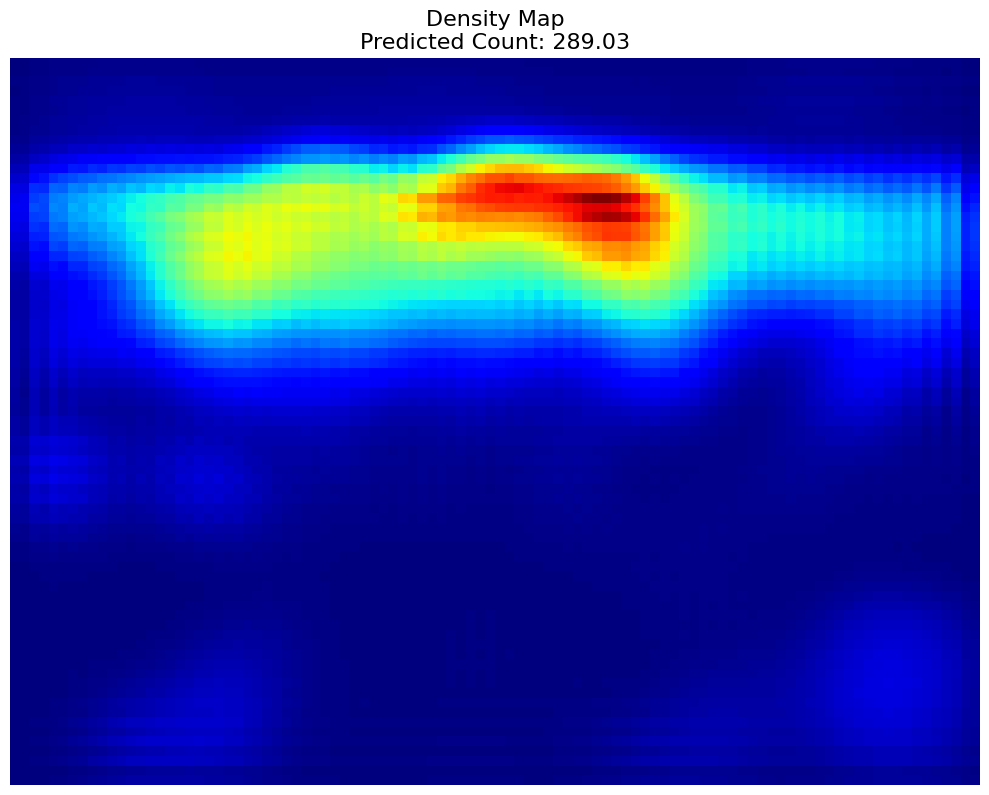

In [16]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_paths_A = "/content/112.jpeg"  # or loop through
img = Image.open(img_paths_A).convert('RGB')
img_tensor = transform(img).unsqueeze(0)

with torch.no_grad():
    output = model(img_tensor)

predicted_count = output.sum().item()

# Display Density Map and Predicted Count
plt.figure(figsize=(10, 8))
plt.imshow(output.squeeze().numpy(), cmap='jet')
plt.title(f'Density Map\nPredicted Count: {predicted_count:.2f}', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

The history output shown model trainned and tested with dataset using Global Gaussian method, the Geometry Adaptive Gaussian method of dataset is trainned and tested using the same code but differ .ipynb file -> training_cbam and training_csrnet